In [5]:
import pydicom # read dicom files
import os # do directory ops
import pandas as pd # data analysis
import numpy as np # array ops
import math
import cv2 # image processin


# plotting
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

data_dir = "./data/train/"
patients = os.listdir(data_dir)
train_df = pd.read_csv("./data/train.csv")

train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


begin to iterate through the patients and gather their respective data. We're almost certainly going to need to do some preprocessing of this data

In [6]:
for patient in patients[:5]:
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    patient_history_df = train_df[train_df.Patient == patient].sort_values(by="Weeks")
    print(len(slices), slices[0].pixel_array.shape)

31 (512, 512)
205 (512, 512)
253 (512, 512)
67 (512, 512)
106 (512, 512)


In [7]:
len(patients)

177

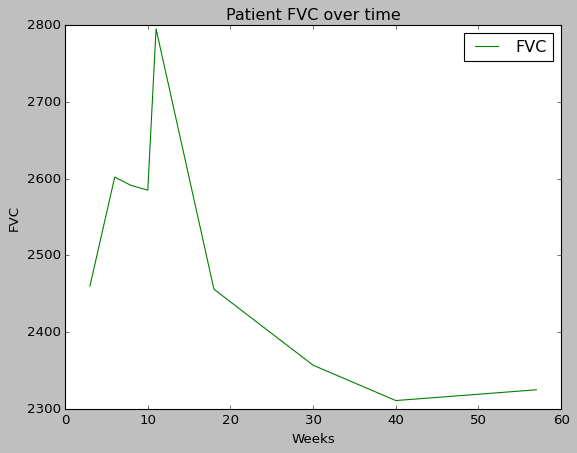

In [8]:
patient_history_df.plot(kind='line',x='Weeks',y='FVC',color='green')
plt.ylabel("FVC")
plt.title("Patient FVC over time")
plt.show()

## Resizing & Visualizing DICOM slices

In [21]:
IMG_PX_SIZE = 50
HM_SLICES = 10

def chunks(lst, n):
    # source link: https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def mean(l):
    return sum(l)/len(l)


def process_data(patient, patient_history_df, img_px_size=50, hm_slices=10, visualize=False):
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    # each scan is not the same depth (number of slices), we we group the slices into chunks of size HM_SLICES
    # and average across them to make sure the dimensionality is standardized
    
    new_slices = []
    
    slices = [cv2.resize(np.array(each_slice.pixel_array), (IMG_PX_SIZE, IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    # accounting for rounding errors by averaging the last slice or two if necessary
    if len(new_slices) == HM_SLICES - 1:
        new_slices.append(new_slices[-1])
    
    if len(new_slices) == HM_SLICES - 2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        
    if len(new_slices) == HM_SLICES + 2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1], new_slices[HM_SLICES]])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLIZES-1] = new_val
    
    if len(new_slices) == HM_SLICES + 2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1], new_slices[HM_SLICES]])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLIZES-1] = new_val
        
#     print(len(new_slices))
    
    
    if visualize:
        fig = plt.figure()
        for num, each_slice in enumerate(new_slices):
            y = fig.add_subplot(2, 5, num+1)
            y.imshow(each_slice, cmap="gray")
        plt.show()
    
    relevant_side_info = patient_history_df[["Patient", "Weeks", "FVC", "Percent"]]
    
    return np.array(new_slices), relevant_side_info
    
    

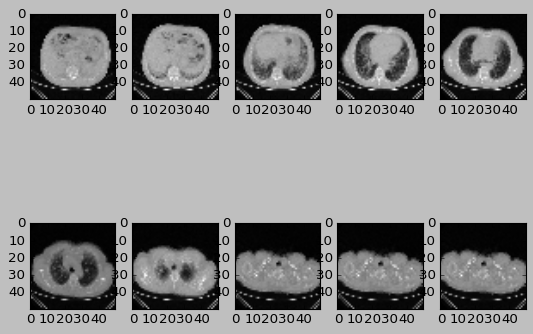

,Patient,Weeks,FVC,Percent
1081,ID00296637202279895784347,5,2223,66.003563
1082,ID00296637202279895784347,8,2099,62.321853
1083,ID00296637202279895784347,10,2258,67.042755
1084,ID00296637202279895784347,12,2130,63.242280
1085,ID00296637202279895784347,13,2163,64.222090
1086,ID00296637202279895784347,20,1990,59.085511
1087,ID00296637202279895784347,32,2210,65.617577
1088,ID00296637202279895784347,44,2166,64.311164


In [23]:
error_log = []
for patient in patients[:1]:
    patient_history_df = train_df[train_df.Patient == patient].sort_values(by="Weeks")
    try:
        slices, df = process_data(patient, patient_history_df, visualize=1)
    except Exception as e:
        error_log.append((patient, e))
        continue
df

I'm thinking we can use the baseline CT scan as the image in a 3D-CNN as part of a wide and deep network. We have side information (Age, Smoker Status, Gender) that we can feed into the wide part, and it will be conditioned on the "Weeks since baseline scan" as a final wide variable in the network.

The way we'd train the model is on tuples like (CT Scan, Weeks) --> FVC. Meaning for one patient, if they have 7 FVC measurements at different times, we'll have 7 training rows, 1 for each measurement, and the target is the FVC at that time.
- we may want to use FVC Percent instead of FVC, so we'll see
- this approach makes it questionable if we'll want to use measurements from before the scan (negative weeks)
- looking like we're going to want to use a significant amount of pre-processing here (besides simple resizing & translations to line shit up, we'll need to threshold and potentially segment the images further if we want to use full res images in some way)


Since the number of slices aren't the same per scan or per patient, we'll want to do some sort of "chunking" like I've done here to make sure we have the same depth of "slices" for each baseline scan.
